In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
from local_utils import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device3 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Circuit 3954 PDEs

> The Brusselator PDEs for two species are
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

for diffusion constants $D_u$, $D_v$, and model parameters $A, B > 0$.
Therefore, the kinetic terms are

<h3><center>$f(u,v) = A - (B+1)u + u^2v$</center></h3>
<h3><center>$g(u,v) = Bu - u^2 v$</center></h3>

<h3><center>$u^* = A$</center></h3>
<h3><center>$v^* = \frac{B}{A}$</center></h3>



In [3]:
with open('../Three_nodes_models/circuit_3954/outputs/indices.npy', 'rb') as f:
    indices = np.load(f)

In [4]:
def load_dataset(index):
    with open(f"../Three_nodes_models/circuit_3954/outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"../Three_nodes_models/circuit_3954/outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"../Three_nodes_models/circuit_3954/outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"../Three_nodes_models/circuit_3954/outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


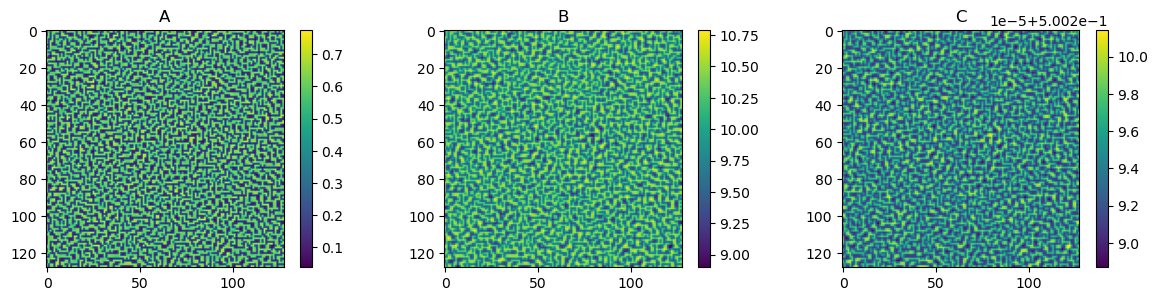

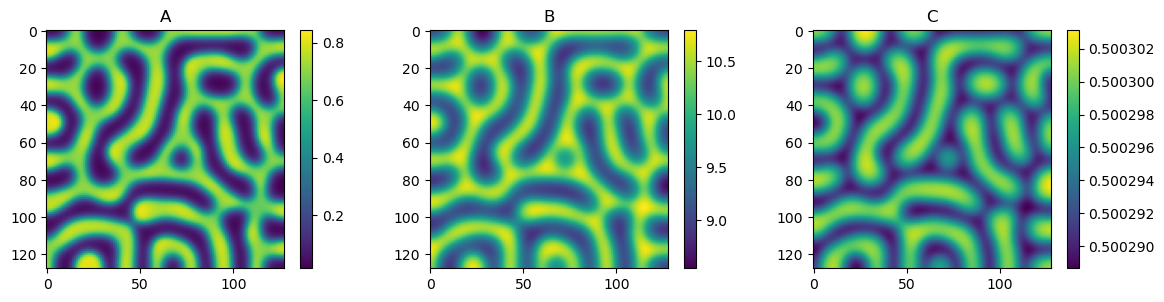

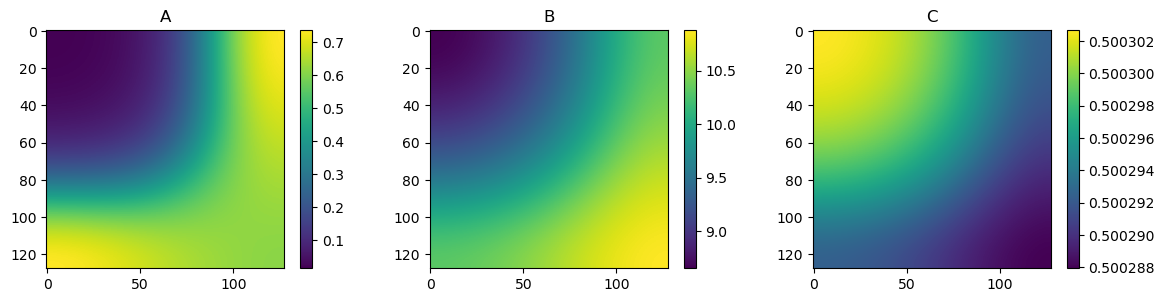

In [5]:
index = 2
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])
plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
def grad_diff(c_c):
    dc = np.zeros_like(c_c)
    for i in range(c_c.shape[0]):
        for j in range(c_c.shape[1]):
            # Periodic boundary condition
            i_prev = (i - 1) % c_c.shape[0]
            i_next = (i + 1) % c_c.shape[0]

            j_prev = (j - 1) % c_c.shape[1]
            j_next = (j + 1) % c_c.shape[1]
            dc[i, j] = (
                    c_c[i_prev, j]
                    + c_c[i_next, j]
                    + c_c[i, j_prev]
                    + c_c[i, j_next]
                    - 4.0 * c_c[i, j]
                ) 
    return dc

In [7]:
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import *

In [8]:
kinetics = create_circuit_3954(params["n"], 
                               params["b_A"], params["mu_A"], params["V_A"], 
                               params["K_AA"], params["K_AB"], params["K_AC"],
                               params["b_B"], params["mu_B"], params["V_B"], 
                               params["K_BA"], params["K_BC"],
                               params["b_C"], params["mu_C"], params["V_C"], 
                               params["K_CB"], params["K_CC"])

In [9]:
T=1
L=10
res = res_128_10
data = reshape(res, T)
maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

res.shape, data.shape, maxs, mins

((10, 3, 16384),
 (3, 128, 128, 1),
 array([ 0.84391719, 10.79269386,  0.50030314]),
 array([0.01473081, 8.54637694, 0.50028865]))

In [10]:
AK, BK, CK = kinetics(data[0, :, :, -1], data[1, :, :, -1], data[2, :, :, -1])
A_Lap = grad_diff(data[0, :, :, -1])
B_Lap = grad_diff(data[1, :, :, -1])

dAdt = (128*128/(10*10))*params["D_A"]* A_Lap[1:-1, 1:-1] + AK[1:-1, 1:-1]
dBdt = (128*128/(10*10))*params["D_B"]* B_Lap[1:-1, 1:-1] + BK[1:-1, 1:-1]
dCdt = CK[1:-1, 1:-1]

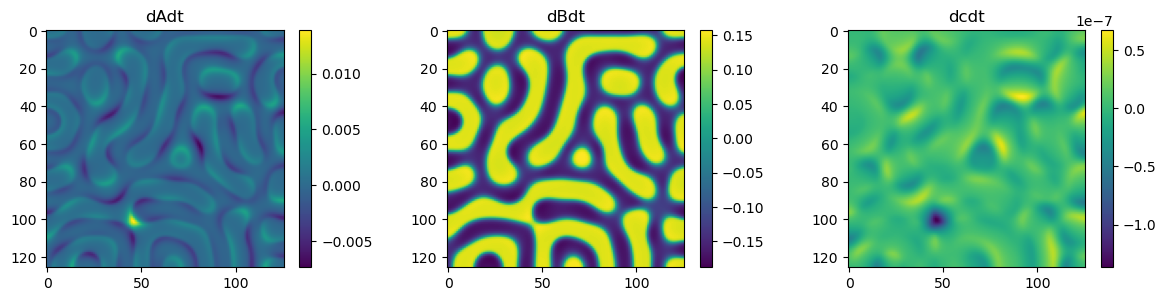

In [11]:
plot_n_im([dAdt, dBdt, dCdt], 
          ["dAdt", "dBdt", "dcdt"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [12]:
torch.manual_seed(42)
np.random.seed(42)


def create_var():
    #return torch.nn.Parameter(torch.ones(1, requires_grad=True, device="cuda")).to(device), []
    return torch.nn.Parameter(torch.ones(1, requires_grad=True, device="cuda:1")), []

D_A=params['D_A']#, sampled_D_A = create_var()
D_B=params['D_B']#, sampled_D_B = create_var()
b_A, sampled_b_A = create_var()
b_B, sampled_b_B = create_var()
b_C, sampled_b_C = create_var()
V_A, sampled_V_A = create_var()
V_B, sampled_V_B = create_var()
V_C, sampled_V_C = create_var()
mu_A, sampled_mu_A = create_var()
mu_B, sampled_mu_B = create_var()
mu_C, sampled_mu_C = create_var()
K_AA, sampled_K_AA = create_var()
K_AB, sampled_K_AB = create_var()
K_AC, sampled_K_AC = create_var()
K_BA, sampled_K_BA = create_var()
K_BC, sampled_K_BC = create_var()
K_CB, sampled_K_CB = create_var()
K_CC, sampled_K_CC = create_var()
n = params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", "mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", "K_CC"]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC]

params_sampled_list =[#sampled_D_A, sampled_D_B,
                      sampled_b_A, sampled_b_B, sampled_b_C, sampled_V_A, sampled_V_B, sampled_V_C,
                      sampled_mu_A, sampled_mu_B, sampled_mu_C,
                      sampled_K_AA, sampled_K_AB, sampled_K_AC, sampled_K_BA, sampled_K_BC,
                      sampled_K_CB, sampled_K_CC]

x = torch.linspace(0, L, 128)[1:-1].to(device)
y = torch.linspace(0, L, 128)[1:-1].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

physics_X = data_X

data_A = torch.from_numpy(data[0, 1:-1, 1:-1, -1].flatten())
data_B = torch.from_numpy(data[1, 1:-1, 1:-1, -1].flatten())
data_C = torch.from_numpy(data[2, 1:-1, 1:-1, -1].flatten())
data_f = torch.vstack([data_A, data_B, data_C]).T.to(device)

dAdt_correction = torch.from_numpy(dAdt.flatten()).to(device)
dBdt_correction = torch.from_numpy(dBdt.flatten()).to(device)
dCdt_correction = torch.from_numpy(dCdt.flatten()).to(device)

print("-------------------------------------")
print(data_X.shape, data_f.shape, 
      dAdt_correction.shape, dBdt_correction.shape, dCdt_correction.shape)
print("-------------------------------------")

lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([L, L]).to(device)
model = Net_dense_normalised([2, 128, 128, 128, 128, 3], lb, ub).to(device)

optimizer = torch.optim.Adam(list(model.parameters()) + params_list,lr=1e-4)
epochs = 500000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_A_physics = 1e-1
lambda_B_physics = 1e-1
lambda_C_physics = 1e-1


#D_A, D_B = D_A.to(device), D_A.to(device)
# b_A, b_B, b_C = b_A.to(device), b_B.to(device), b_C.to(device)
# V_A, V_B, V_C = V_A.to(device), V_B.to(device), V_C.to(device)
# mu_A, mu_B, mu_C = mu_A.to(device), mu_B.to(device), mu_C.to(device)
# K_AA, K_AB, K_AC = K_AA.to(device), K_AB.to(device), K_AC.to(device)
# K_BA, K_BC = K_BA.to(device), K_BC.to(device)
# K_CB, K_CC = K_CB.to(device), K_CC.to(device)
# params_list = [#D_A, D_B, 
#                b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C,
#                K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC]

losses = np.zeros((6, epochs))

def act(x, km, n=2):
    return 1 / (1 + (km / (x + 1e-20)) ** (n))

def inh(x, km, n=2):
    return 1 / (1 + (x / (km + 1e-20)) ** (n))

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    # randomly select 1/4th of them
    random_indices = torch.randperm(data_X.shape[0])[:(126*126)//126]
    data_f_hat = model(data_X[random_indices,:]).squeeze()    
    loss_data = torch.mean((data_f[random_indices,:] - data_f_hat)**2)


    #################################
    # physics derivatives
    # random points
    #physics_X = (torch.rand(((126*126)*2,2))*L).requires_grad_(True).to(device)
    physics_f = model(physics_X)    
    A = physics_f[:,0].squeeze()
    B = physics_f[:,1].squeeze()
    C = physics_f[:,2].squeeze()
    dxy  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy),  create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacian = dx2 + dy2
        
    
    # To make sure the parameters stay positive, we use the exponential function    
    e = torch.exp
    F_A =  e(b_A) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n) - e(mu_A) * A
    #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
    F_B =  e(b_B) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n) - e(mu_B) * B
    F_C =  e(b_C) + e(V_C)*inh(A, e(K_AC), n)*inh(B, e(K_BC), n)*act(C, e(K_CC), n) - e(mu_C) * C

    
    #dAdt = e(D_A) * laplacian + F_A
    dAdt = D_A * laplacian + F_A - dAdt_correction
    #dAdt2 = laplacian + f_A
    #dBdt = e(D_B) * laplacian + F_B
    dBdt = D_B * laplacian + F_B - dBdt_correction
    #dBdt2 = laplacian + f_B
    dCdt = F_C - dCdt_correction
    ################################
    # physics loss
    # Construct the physics loss here
    A_loss_physics = torch.mean(dAdt**2)
    #A2_loss_physics = torch.mean(dAdt2**2)
    B_loss_physics = torch.mean(dBdt**2)
    #B2_loss_physics = torch.mean(dBdt2**2)
    C_loss_physics = torch.mean(dCdt**2)
    loss_physics = (lambda_A_physics*A_loss_physics #+ A2_loss_physics 
                    +lambda_B_physics*B_loss_physics #+ B2_loss_physics 
                    +lambda_C_physics*C_loss_physics)
    
    total_loss = (
        +lambda_data*loss_data
        +loss_physics        
                    )

    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    losses[:,i] = (loss_data.item(), 
                   A_loss_physics.item(),0,# A2_loss_physics.item(),
                   B_loss_physics.item(), 0,#B2_loss_physics.item(),
                   C_loss_physics.item())
    if (i+1)%5000 == 0 or i==0:
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{losses[0,i]:.6f}, \n"
              f"A loss:{losses[1,i]:.6f}, A2 loss:{losses[2,i]:.6f}, \n"
              f"B loss:{losses[3,i]:.6f}, B2 loss:{losses[4,i]:.6f},\n"
              f"C loss:{losses[5,i]:.6f}"
              f"\n"
              ,
              ", ".join([f"{name}={np.exp(param.item()):.4f}" for param, name in zip(params_list, params_name_list)])
             )
    
    for param, param_list in zip(params_list, params_sampled_list):
        param_list.append(param.item())    

-------------------------------------
torch.Size([15876, 2]) torch.Size([15876, 3]) torch.Size([15876]) torch.Size([15876]) torch.Size([15876])
-------------------------------------
Epoch: 1 
 data loss:33.252903, 
A loss:7.420011, A2 loss:0.000000, 
B loss:8.393706, B2 loss:0.000000,
C loss:6.504527
 b_A=2.7180, b_B=2.7180, b_C=2.7180, V_A=2.7182, V_B=2.7182, V_C=2.7180, mu_A=2.7180, mu_B=2.7180, mu_C=2.7186, K_AA=2.7184, K_AB=2.7184, K_AC=2.7183, K_BA=2.7183, K_BC=2.7183, K_CB=2.7183, K_CC=2.7186
Epoch: 5000 
 data loss:2.388707, 
A loss:0.096240, A2 loss:0.000000, 
B loss:10.178969, B2 loss:0.000000,
C loss:0.354835
 b_A=3.7332, b_B=4.3025, b_C=1.9948, V_A=3.9857, V_B=5.0987, V_C=2.5697, mu_A=1.9822, mu_B=1.7265, mu_C=2.9055, K_AA=1.9330, K_AB=1.5437, K_AC=2.5965, K_BA=3.9767, K_BC=2.5692, K_CB=4.3876, K_CC=2.8826
Epoch: 10000 
 data loss:0.366222, 
A loss:0.047245, A2 loss:0.000000, 
B loss:0.267936, B2 loss:0.000000,
C loss:0.018667
 b_A=2.8854, b_B=6.2802, b_C=1.5173, V_A=3.9588,

Epoch: 110000 
 data loss:0.023504, 
A loss:0.000686, A2 loss:0.000000, 
B loss:0.037730, B2 loss:0.000000,
C loss:0.000187
 b_A=0.3021, b_B=5.4918, b_C=0.1669, V_A=4.9021, V_B=22.2674, V_C=3.5015, mu_A=1.8121, mu_B=1.4084, mu_C=0.5708, K_AA=0.5227, K_AB=0.4517, K_AC=16.4723, K_BA=8.1246, K_BC=5.1795, K_CB=0.7967, K_CC=0.5182
Epoch: 115000 
 data loss:0.021818, 
A loss:0.000581, A2 loss:0.000000, 
B loss:0.037825, B2 loss:0.000000,
C loss:0.000140
 b_A=0.2478, b_B=5.3804, b_C=0.1485, V_A=4.6428, V_B=23.0330, V_C=3.3035, mu_A=1.5775, mu_B=1.4310, mu_C=0.4932, K_AA=0.5238, K_AB=0.4496, K_AC=16.6076, K_BA=7.9998, K_BC=5.0410, K_CB=0.7912, K_CC=0.5278
Epoch: 120000 
 data loss:0.021479, 
A loss:0.000484, A2 loss:0.000000, 
B loss:0.042734, B2 loss:0.000000,
C loss:0.000102
 b_A=0.1996, b_B=5.2796, b_C=0.1301, V_A=4.4013, V_B=23.7589, V_C=3.1086, mu_A=1.3676, mu_B=1.4521, mu_C=0.4212, K_AA=0.5249, K_AB=0.4481, K_AC=16.7045, K_BA=7.8767, K_BC=4.8997, K_CB=0.7862, K_CC=0.5365
Epoch: 125000 
 

Epoch: 220000 
 data loss:0.009121, 
A loss:0.000242, A2 loss:0.000000, 
B loss:0.049049, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0004, b_B=4.2607, b_C=0.0026, V_A=2.6883, V_B=32.8701, V_C=1.2422, mu_A=0.5630, mu_B=1.7079, mu_C=0.0068, K_AA=0.5338, K_AB=0.4448, K_AC=16.8908, K_BA=7.9912, K_BC=2.3247, K_CB=0.7364, K_CC=0.7304
Epoch: 225000 
 data loss:0.009284, 
A loss:0.000259, A2 loss:0.000000, 
B loss:0.035243, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0003, b_B=4.2357, b_C=0.0024, V_A=2.6450, V_B=33.1520, V_C=1.2361, mu_A=0.5669, mu_B=1.7153, mu_C=0.0062, K_AA=0.5336, K_AB=0.4451, K_AC=16.8908, K_BA=8.0495, K_BC=2.2890, K_CB=0.7356, K_CC=0.7391
Epoch: 230000 
 data loss:0.011213, 
A loss:0.000259, A2 loss:0.000000, 
B loss:0.025995, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0002, b_B=4.2118, b_C=0.0022, V_A=2.6030, V_B=33.4219, V_C=1.2312, mu_A=0.5710, mu_B=1.7225, mu_C=0.0057, K_AA=0.5331, K_AB=0.4453, K_AC=16.8908, K_BA=8.1111, K_BC=2.2602, K_CB=0.7348, K_CC=0.7474
Epoch: 235000 
 

Epoch: 330000 
 data loss:0.006394, 
A loss:0.000363, A2 loss:0.000000, 
B loss:0.019068, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0000, b_B=3.9232, b_C=0.0011, V_A=1.8232, V_B=37.4660, V_C=1.2056, mu_A=0.6333, mu_B=1.8104, mu_C=0.0028, K_AA=0.5245, K_AB=0.4540, K_AC=16.8908, K_BA=9.5413, K_BC=2.1071, K_CB=0.7331, K_CC=0.8773
Epoch: 335000 
 data loss:0.004907, 
A loss:0.000359, A2 loss:0.000000, 
B loss:0.030565, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0000, b_B=3.9145, b_C=0.0011, V_A=1.7857, V_B=37.6147, V_C=1.2055, mu_A=0.6358, mu_B=1.8131, mu_C=0.0028, K_AA=0.5238, K_AB=0.4545, K_AC=16.8908, K_BA=9.6348, K_BC=2.1067, K_CB=0.7334, K_CC=0.8822
Epoch: 340000 
 data loss:0.006400, 
A loss:0.000377, A2 loss:0.000000, 
B loss:0.016276, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0000, b_B=3.9063, b_C=0.0011, V_A=1.7487, V_B=37.7588, V_C=1.2053, mu_A=0.6380, mu_B=1.8156, mu_C=0.0027, K_AA=0.5232, K_AB=0.4550, K_AC=16.8908, K_BA=9.7328, K_BC=2.1057, K_CB=0.7338, K_CC=0.8872
Epoch: 345000 
 

Epoch: 440000 
 data loss:0.003404, 
A loss:0.000489, A2 loss:0.000000, 
B loss:0.014712, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0000, b_B=3.7916, b_C=0.0009, V_A=1.2104, V_B=39.8542, V_C=1.2023, mu_A=0.6736, mu_B=1.8513, mu_C=0.0022, K_AA=0.5112, K_AB=0.4646, K_AC=16.8908, K_BA=12.0228, K_BC=2.0901, K_CB=0.7439, K_CC=0.9647
Epoch: 445000 
 data loss:0.004058, 
A loss:0.000485, A2 loss:0.000000, 
B loss:0.012804, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0000, b_B=3.7878, b_C=0.0009, V_A=1.1957, V_B=39.9297, V_C=1.2021, mu_A=0.6752, mu_B=1.8524, mu_C=0.0021, K_AA=0.5107, K_AB=0.4650, K_AC=16.8908, K_BA=12.1353, K_BC=2.0889, K_CB=0.7445, K_CC=0.9677
Epoch: 450000 
 data loss:0.003406, 
A loss:0.000479, A2 loss:0.000000, 
B loss:0.032561, B2 loss:0.000000,
C loss:0.000000
 b_A=0.0000, b_B=3.7840, b_C=0.0009, V_A=1.1820, V_B=40.0013, V_C=1.2019, mu_A=0.6764, mu_B=1.8537, mu_C=0.0021, K_AA=0.5104, K_AB=0.4654, K_AC=16.8908, K_BA=12.2445, K_BC=2.0875, K_CB=0.7452, K_CC=0.9707
Epoch: 455000

In [ ]:
b_A=0.0010, b_B=0.1000, b_C=0.5000, V_A=10.0000, V_B=25.0000, V_C=50.0000, mu_A=0.50, mu_B=1.00, mu_C=1.00, 
K_AA=0.5000, K_AB=0.5000, K_AC=5.0000, K_BA=5.0000, K_BC=20.0000, K_CB=50.0000, K_CC=10.0000

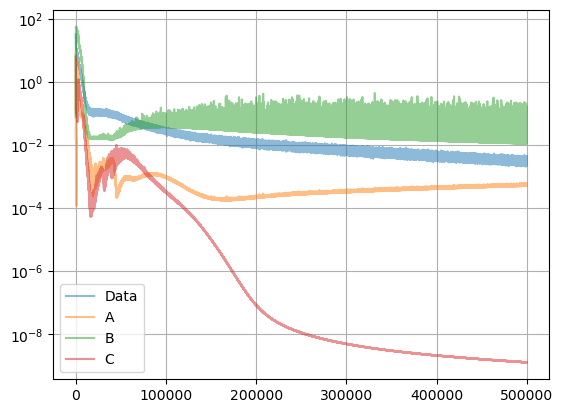

b_A=0.0000, b_B=3.7549, b_C=0.0008, V_A=1.0972, V_B=40.5810, V_C=1.1995, mu_A=0.6879, mu_B=1.8626, mu_C=0.0020, K_AA=0.5077, K_AB=0.4690, K_AC=16.8908, K_BA=13.1070, K_BC=2.0726, K_CB=0.7516, K_CC=0.9966

Actual
b_A=0.0010, b_B=0.1000, b_C=0.5000, V_A=10.0000, V_B=25.0000, V_C=50.0000, mu_A=0.5000, mu_B=1.0000, mu_C=1.0000, K_AA=0.5000, K_AB=0.5000, K_AC=5.0000, K_BA=5.0000, K_BC=20.0000, K_CB=50.0000, K_CC=10.0000


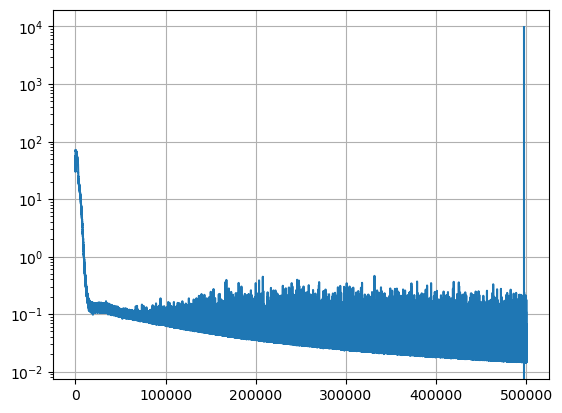

In [13]:
plt.plot(losses[0,:], alpha=.5, label="Data")
plt.plot(losses[1,:], alpha=.5, label="A")
#plt.plot(losses[2,:], alpha=.5, label="A2")
plt.plot(losses[3,:], alpha=.5, label="B")
#plt.plot(losses[4,:], alpha=.5, label="B2")
plt.plot(losses[5,:], alpha=.5, label="C")
plt.yscale('log');plt.grid();plt.legend();plt.show()
plt.plot(np.sum(losses, axis=0))

index = np.argmin(np.sum(losses, axis=0)[20:])
print(", ".join([f"{name}={np.exp(l[index]):.4f}" 
                 for l, name in zip(params_sampled_list, params_name_list)]))
print()

print("Actual")
print(", ".join([f"{name}={params[name]:.4f}" 
                 for name in params_name_list]))

plt.yscale('log'); plt.vlines(index, 0, 10000);plt.grid();

plt.show()

b_A=0.0000, b_B=3.7537, b_C=0.0008, V_A=1.0946, V_B=40.6081, V_C=1.1994, mu_A=0.6884, mu_B=1.8630, mu_C=0.0020, K_AA=0.5076, K_AB=0.4691, K_AC=16.8908, K_BA=13.1415, K_BC=2.0718, K_CB=0.7520, K_CC=0.9978
Actual
b_A=0.0010, b_B=0.1000, b_C=0.5000, V_A=10.0000, V_B=25.0000, V_C=50.0000, mu_A=0.5000, mu_B=1.0000, mu_C=1.0000, K_AA=0.5000, K_AB=0.5000, K_AC=5.0000, K_BA=5.0000, K_BC=20.0000, K_CB=50.0000, K_CC=10.0000


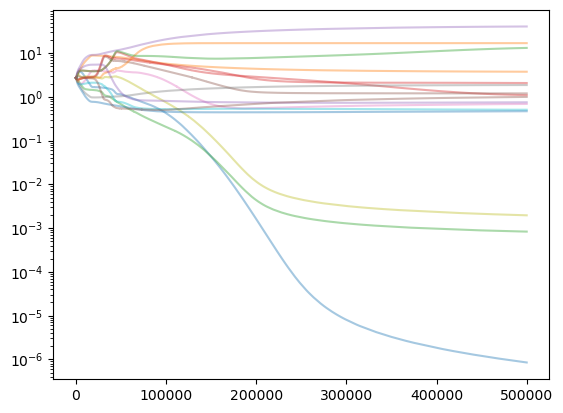

In [14]:
index = -1
print(", ".join([f"{name}={np.exp(l[index]):.4f}" 
                 for l, name in zip(params_sampled_list, params_name_list)]))

print("Actual")
print(", ".join([f"{name}={params[name]:.4f}" 
                 for name in params_name_list]))

for l, name in zip(params_sampled_list, params_name_list):
    plt.plot(np.exp(l), alpha=.4, label=f"{name}")

#plt.vlines(index, 0, 11);plt.grid()
plt.yscale('log')
plt.show()



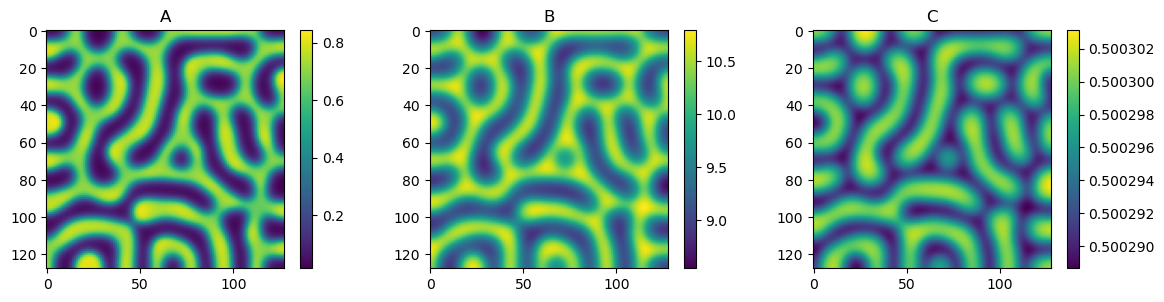

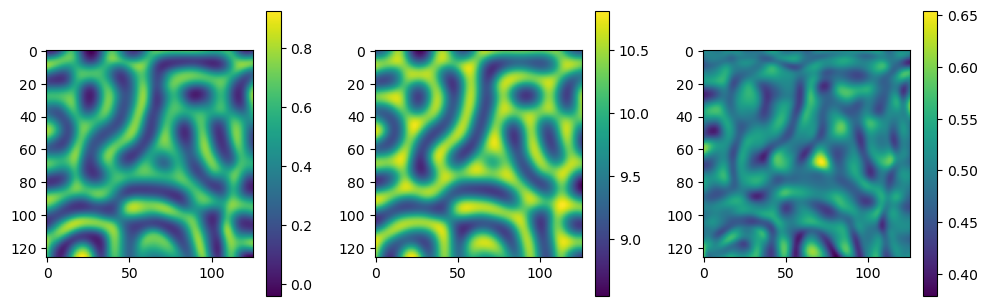

In [15]:
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

solution = model(data_X).cpu().detach()
A_hat = solution[:, 0].reshape((126, 126))
B_hat = solution[:, 1].reshape((126, 126))
C_hat = solution[:, 2].reshape((126, 126))
index = -1
_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

In [16]:
model_128_10 = RD_2D_1st_Order(Ds=[params["D_A"], params["D_B"], 0], delta_t=99/4950, Lx=10, Ly=10, 
                            Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D
                       #boundary_condition=Periodic_Boundary_2D
                       # boundary_condition=Diritchlet_Boundary_2D
                       )

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [17]:
estimated_params = dict()
index = np.argmin(np.sum(losses, axis=0)[20:]) 
for l, name in zip(params_sampled_list, params_name_list):    
    estimated_params[name] = np.exp(l[index])

In [21]:
kinetics = create_circuit_3954(params["n"], 
                               estimated_params["b_A"], estimated_params["mu_A"], estimated_params["V_A"], 
                               estimated_params["K_AA"], estimated_params["K_AB"], estimated_params["K_AC"],
                               estimated_params["b_B"], estimated_params["mu_B"], estimated_params["V_B"], 
                               estimated_params["K_BA"], estimated_params["K_BC"],
                               estimated_params["b_C"], estimated_params["mu_C"], estimated_params["V_C"], 
                               estimated_params["K_CB"], estimated_params["K_CC"])

In [22]:
res2 = model_128_10.integrate([res_128_10[0, 0, :], res_128_10[0, 1, :], res_128_10[0, 2, :]],kinetics,5000)

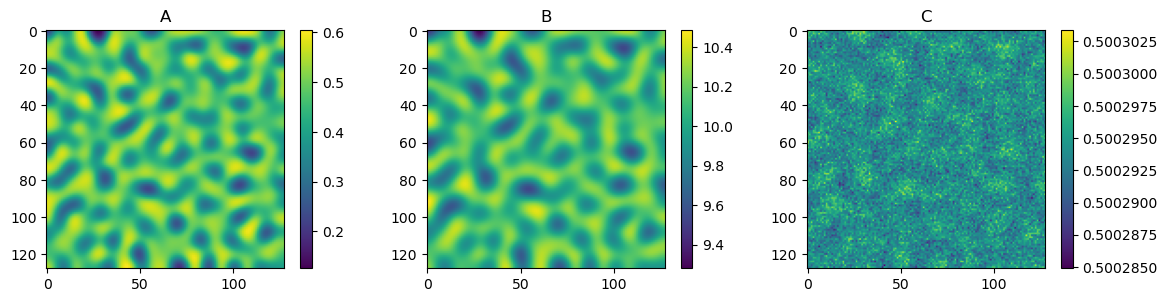

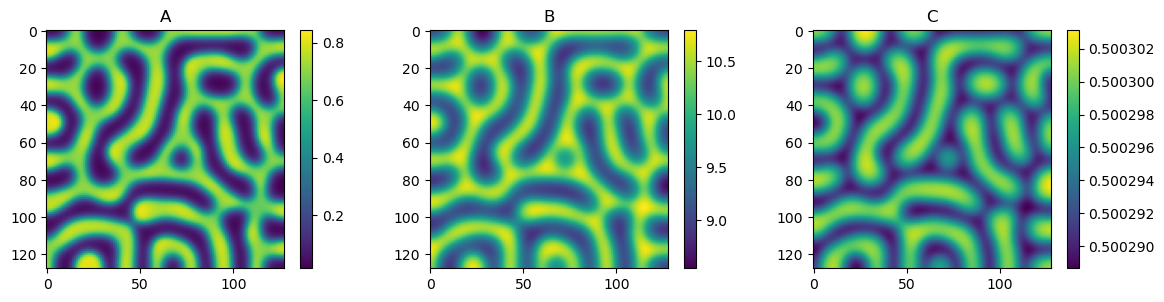

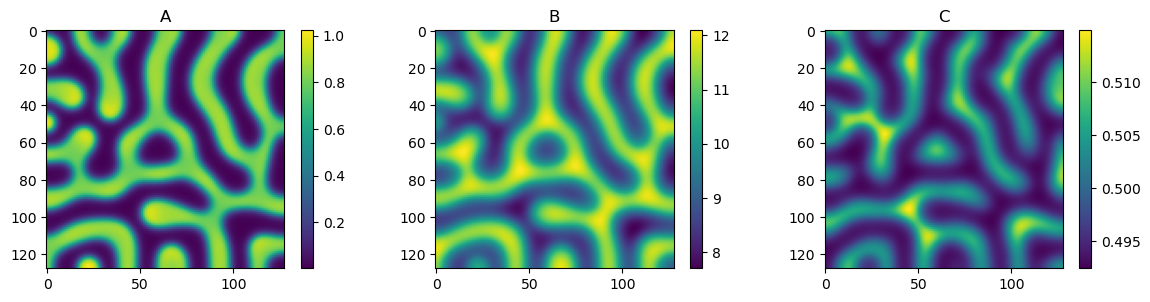

In [20]:
plot_n_im([to(res_128_10[0, 0, :]), to(res_128_10[0, 1, :]), to(res_128_10[0, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(res2[-1, 0, :]), to(res2[-1, 1, :]), to(res2[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [53]:
dAdt.shape

(126, 126)

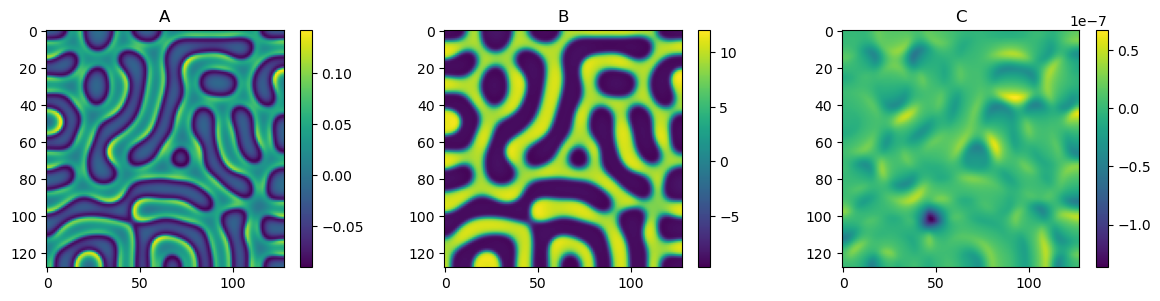

2.458751950811007e-06 0.016504198882792722 2.6956164344427896e-16


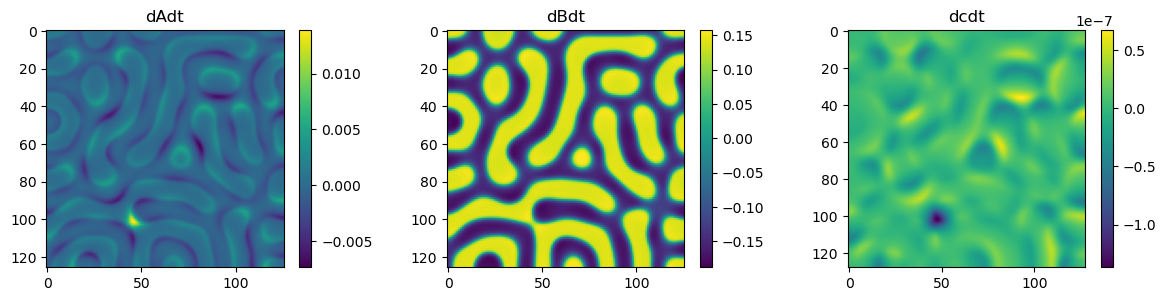

In [57]:
plot_n_im([AK, BK, CK], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

# plot_n_im([A_Lap, B_Lap], 
#           ["Lap A", "Lap B", ],          
#           figsize=(12, 3)); plt.tight_layout();plt.show()

dAdt = (128*128/(10*10))*params["D_A"]* A_Lap[1:-1, 1:-1] + AK[1:-1, 1:-1]
dBdt = (128*128/(10*10))*params["D_B"]* B_Lap[1:-1, 1:-1] + BK[1:-1, 1:-1]
dCdt = CK
print(np.mean((dAdt)**2), np.mean((dBdt)**2), np.mean((dCdt)**2))

plot_n_im([dAdt, dBdt, dCdt], 
          ["dAdt", "dBdt", "dcdt"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [59]:
losses[1:, -1]

array([1.23570760e-06, 0.00000000e+00, 4.58647078e-03, 0.00000000e+00,
       8.50419838e-07])

In [ ]:
torch.manual_seed(42)
np.random.seed(42)


def create_var():
    return torch.nn.Parameter(torch.ones(1), requires_grad=True), []

D_A=params['D_A']#, sampled_D_A = create_var()
D_B=params['D_B']#, sampled_D_B = create_var()
b_A, sampled_b_A = create_var()
b_B, sampled_b_B = create_var()
b_C, sampled_b_C = create_var()
V_A, sampled_V_A = create_var()
V_B, sampled_V_B = create_var()
V_C, sampled_V_C = create_var()
mu_A, sampled_mu_A = create_var()
mu_B, sampled_mu_B = create_var()
mu_C, sampled_mu_C = create_var()
K_AA, sampled_K_AA = create_var()
K_AB, sampled_K_AB = create_var()
K_AC, sampled_K_AC = create_var()
K_BA, sampled_K_BA = create_var()
K_BC, sampled_K_BC = create_var()
K_CB, sampled_K_CB = create_var()
K_CC, sampled_K_CC = create_var()
n = params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", "mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", "K_CC"]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC]

params_sampled_list =[#sampled_D_A, sampled_D_B,
                      sampled_b_A, sampled_b_B, sampled_b_C, sampled_V_A, sampled_V_B, sampled_V_C,
                      sampled_mu_A, sampled_mu_B, sampled_mu_C,
                      sampled_K_AA, sampled_K_AB, sampled_K_AC, sampled_K_BA, sampled_K_BC,
                      sampled_K_CB, sampled_K_CC]

x = torch.linspace(0, L, 128)[1:-1].to(device)
y = torch.linspace(0, L, 128)[1:-1].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

physics_X = data_X

data_A = torch.from_numpy(data[0, 1:-1, 1:-1, -1].flatten()).to(device)
data_B = torch.from_numpy(data[1, 1:-1, 1:-1, -1].flatten()).to(device)
data_C = torch.from_numpy(data[2, 1:-1, 1:-1, -1].flatten()).to(device)
#data_f = torch.vstack([data_A, data_B, data_C]).T.to(device)

dAdt_correction = torch.from_numpy(dAdt.flatten()).to(device)
dBdt_correction = torch.from_numpy(dBdt.flatten()).to(device)
dCdt_correction = torch.from_numpy(dCdt.flatten()).to(device)

print("-------------------------------------")
print(data_X.shape, 
      dAdt_correction.shape, dBdt_correction.shape, dCdt_correction.shape)
print("-------------------------------------")

lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([L, L]).to(device)
model = Net_sep_dense_normalised(2, 3, [128, 128, 128, 128], lb, ub).to(device)

optimizer = torch.optim.Adam([*model.parameters()] + params_list,lr=1e-4)


#D_A, D_B = D_A.to(device), D_A.to(device)
b_A, b_B, b_C = b_A.to(device), b_B.to(device), b_C.to(device)
V_A, V_B, V_C = V_A.to(device), V_B.to(device), V_C.to(device)
mu_A, mu_B, mu_C = mu_A.to(device), mu_B.to(device), mu_C.to(device)
K_AA, K_AB, K_AC = K_AA.to(device), K_AB.to(device), K_AC.to(device)
K_BA, K_BC = K_BA.to(device), K_BC.to(device)
K_CB, K_CC = K_CB.to(device), K_CC.to(device)
params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC]
    

epochs = 200000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_A_physics = 1e-3
lambda_B_physics = 1e-3
lambda_C_physics = 1e-3

losses = np.zeros((6, epochs))

def act(x, km, n=2):
    return 1 / (1 + (km / (x + 1e-20)) ** (n))

def inh(x, km, n=2):
    return 1 / (1 + (x / (km + 1e-20)) ** (n))

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    # randomly select 1/4th of them
    random_indices = torch.randperm(data_X.shape[0])[:(126*126)//126]
    data_f_hat = model(data_X[random_indices,:])
    data_A_hat = data_f_hat[0].squeeze()
    data_B_hat = data_f_hat[1].squeeze()
    data_C_hat = data_f_hat[2].squeeze()    
    loss_data = torch.mean((data_A[random_indices] - data_A_hat)**2 +
                           (data_B[random_indices] - data_B_hat)**2 +
                           (data_C[random_indices] - data_C_hat)**2)/3


    #################################
    # physics derivatives
    # random points
    #physics_X = (torch.rand(((126*126)*2,2))*L).requires_grad_(True).to(device)
    physics_f = model(physics_X)
    A = physics_f[0]
    B = physics_f[1]
    C = physics_f[1]
    dxyA  = torch.autograd.grad(A, physics_X, torch.ones_like(A), create_graph=True)[0]# computes dy/dx
    dxA, dyA = dxyA[:,0], dxyA[:,1]
    dxy2A = torch.autograd.grad(dxA, physics_X, torch.ones_like(dxA),  create_graph=True)[0]# computes d^2u/dx^2
    dx2A =  dxy2A[:,0]
    dyx2A = torch.autograd.grad(dyA, physics_X, torch.ones_like(dyA),  create_graph=True)[0]# computes d^2u/dy^2
    dy2A =  dyx2A[:,1]
    laplacianA = dx2A + dy2A
    
    dxyB  = torch.autograd.grad(B, physics_X, torch.ones_like(B), create_graph=True)[0]# computes dy/dx
    dxB, dyB = dxyB[:,0], dxyB[:,1]
    dxy2B = torch.autograd.grad(dxB, physics_X, torch.ones_like(dxB),  create_graph=True)[0]# computes d^2u/dx^2
    dx2B =  dxy2B[:,0]
    dyx2B = torch.autograd.grad(dyB, physics_X, torch.ones_like(dyB),  create_graph=True)[0]# computes d^2u/dy^2
    dy2B =  dyx2B[:,1]
    laplacianB = dx2B + dy2B
        
    
    # To make sure the parameters stay positive, we use the exponential function    
    e = torch.exp
    F_A =  e(b_A) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n) - e(mu_A) * A
    #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
    F_B =  e(b_B) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n) - e(mu_B) * B
    F_C =  e(b_C) + e(V_C)*inh(A, e(K_AC), n)*inh(B, e(K_BC), n)*act(C, e(K_CC), n) - e(mu_C) * C

    
    #dAdt = e(D_A) * laplacianA + F_A
    dAdt = D_A * laplacianA + F_A - dAdt_correction
    #dAdt2 = laplacianA + f_A
    #dBdt = e(D_B) * laplacianB + F_B
    dBdt = D_B * laplacianB + F_B - dBdt_correction
    #dBdt2 = laplacianB + f_B
    dCdt = F_C - dCdt_correction
    ################################
    # physics loss
    # Construct the physics loss here
    A_loss_physics = torch.mean(dAdt**2)
    #A2_loss_physics = torch.mean(dAdt2**2)
    B_loss_physics = torch.mean(dBdt**2)
    #B2_loss_physics = torch.mean(dBdt2**2)
    C_loss_physics = torch.mean(dCdt**2)
    loss_physics = (lambda_A_physics*A_loss_physics #+ A2_loss_physics 
                    +lambda_B_physics*B_loss_physics #+ B2_loss_physics 
                    +lambda_C_physics*C_loss_physics)
    
    total_loss = (
        +lambda_data*loss_data
        +loss_physics        
                    )

    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    losses[:,i] = (loss_data.item(), 
                   A_loss_physics.item(),0,# A2_loss_physics.item(),
                   B_loss_physics.item(), 0,#B2_loss_physics.item(),
                   C_loss_physics.item())
    if (i+1)%5000 == 0 or i==0:
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{losses[0,i]:.6f}, \n"
              f"A loss:{losses[1,i]:.6f}, A2 loss:{losses[2,i]:.6f}, \n"
              f"B loss:{losses[3,i]:.6f}, B2 loss:{losses[4,i]:.6f},\n"
              f"C loss:{losses[5,i]:.6f}"
              f"\n"
              ,
              ", ".join([f"{name}={np.exp(param.item()):.4f}" for param, name in zip(params_list, params_name_list)])
             )
    
    for param, param_list in zip(params_list, params_sampled_list):
        param_list.append(param.item())    